# FedAvg

Vanila FedAvg

In [1]:
import numpy as np

import copy
import os 
import gc

import torch
from torch import nn, optim, autograd
import torch.nn.functional as F
import torch.nn.init as init

from collections import OrderedDict
import matplotlib.pyplot as plt

# from torch.utils.data import DataLoader, Dataset
# from torchvision import datasets, transforms

# import torch.utils.data as data

In [2]:
print(f'Current GPU: {torch.cuda.current_device()}')
print(f'GPU Name: {torch.cuda.get_device_name()}')
print(f'Number of GPUs: {torch.cuda.device_count()}')
torch.cuda.set_device(1) ## Setting cuda on GPU:0

Current GPU: 0
GPU Name: GeForce GTX 1080 Ti
Number of GPUs: 2


In [3]:
class Args: 
    num_users = 2
    seed = 1
    gpu = 1
    
    ## CIFAR-10 has 50000 training images (5000 per class), 10 classes, 10000 test images (1000 per class)
    ## CIFAR-100 has 50000 training images (500 per class), 100 classes, 10000 test images (100 per class)
    ## MNIST has 60000 training images (min: 5421, max: 6742 per class), 10000 test images (min: 892, max: 1135
    ## per class) --> in the code we fixed 5000 training image per class, and 900 test image per class to be 
    ## consistent with CIFAR-10 
    
    ## CIFAR-10 Non-IID 250 samples per label for 2 class non-iid is the benchmark (500 samples for each client)
    
    nsample_pc = 250  ## number of samples per class for each client 
    nclass = 2        ## number of classes or shards for each client
    model = 'simple-cnn' ## options: lenet5
    dataset = 'cifar10'  ## options: mnist, cifar10, cifar100
    datadir = '../data/'
    logdir = '../logs/'
    partition = 'noniid-#label2'
    alg = 'cluster_fl'
    savedir = '../save/'
    beta = 0.1
    local_view = True
    batch_size= 10
    noise = 0
    noise_type = 'level'
    
    rounds = 30
    frac = 0.1
    local_bs = 10
    local_ep = 5
    lr = 0.01
    momentum = 0.5
    
    cluster_alpha = 3.5
    nclasses = 10 
    nsamples_shared = 2500
    n_basis = 3
    linkage = 'average'
    
    noniid = True
    noniid_iid = False
    shard = True
    label = False
    split_test = False
    
    print_freq = 50
    
    load_initial = ''
    
args = Args()

torch.cuda.set_device(args.gpu) ## Setting cuda on GPU 
#torch.manual_seed(args.seed)
#np.random.seed(args.seed)

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() else 'cpu')

## Dataset NIID Benchmark 

In [4]:
from __future__ import absolute_import
from src.client import * 
from src.utils import *
from src.data import *

In [5]:
# import sys
# sys.path
# import os
# os.getcwd()

In [6]:
args.dataset = 'cifar10'
args.partition='noniid-#label2'
args.num_users=100

args.rounds=100
args.frac = 0.1
args.local_bs = 10
args.local_ep = 10
args.lr = 0.01
args.momentum = 0.9

args.bias=True

args.ordering = 'curr'       #  'curr', "random", "anti_curr"
args.pacing_f = 'linear'     #  'linear', 'quad', 'root', 'step', 'exp', 'log'
args.pacing_a = 0.2 
args.pacing_b = 0.4

In [7]:
train_dl_global, test_dl_global, train_ds_global, test_ds_global = get_dataloader(args.dataset,
                                                                                   args.datadir,
                                                                                   args.batch_size,
                                                                                   32)

print("len train_ds_global:", len(train_ds_global))
print("len test_ds_global:", len(test_ds_global))

Files already downloaded and verified
Files already downloaded and verified
len train_ds_global: 50000
len test_ds_global: 10000


## Model

In [8]:
from src.models import *

In [9]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=10, bias=True):
        super(SimpleCNN, self).__init__()
        self.bias=bias
        self.act=OrderedDict()
        self.input_size =[]
        self.ksize=[]
        self.in_channel =[]
        
        self.conv1 = nn.Conv2d(3, 6, 5, bias=self.bias)
        self.input_size.append(32)
        self.ksize.append(5)
        self.in_channel.append(3)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        s=compute_conv_output_size(32,5)
        s=s//2
        
        self.input_size.append(s)
        self.ksize.append(5)
        self.in_channel.append(6)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=self.bias)

        # for now, we hard coded this network
        # i.e. we fix the number of hidden layers i.e. 2 layers
        s=compute_conv_output_size(s,5)
        s=s//2
        self.input_size.append(s*s*16)
        self.fc1 = nn.Linear(input_dim, hidden_dims[0], bias=self.bias)
        
        self.input_size.append(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1], bias=self.bias)
        
        self.input_size.append(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim, bias=self.bias)

    def forward(self, x):
        self.act['conv1']=x
        x = self.pool(F.relu(self.conv1(x)))
        
        self.act['conv2']=x
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16 * 5 * 5)
        self.act['fc1']=x
        x = F.relu(self.fc1(x))
        
        self.act['fc2']=x
        x = F.relu(self.fc2(x))
        
        self.act['fc3']=x
        x = self.fc3(x)
        return x

In [11]:
def init_nets(args, dropout_p=0.5, bias=True):

    users_model = []

    for net_i in range(-1, args.num_users):
        if args.dataset == "generated":
            net = PerceptronModel().to(args.device)
        elif args.model == "mlp":
            if args.dataset == 'covtype':
                input_size = 54
                output_size = 2
                hidden_sizes = [32,16,8]
            elif args.dataset == 'a9a':
                input_size = 123
                output_size = 2
                hidden_sizes = [32,16,8]
            elif args.dataset == 'rcv1':
                input_size = 47236
                output_size = 2
                hidden_sizes = [32,16,8]
            elif args.dataset == 'SUSY':
                input_size = 18
                output_size = 2
                hidden_sizes = [16,8]
            net = FcNet(input_size, hidden_sizes, output_size, dropout_p).to(args.device)
        elif args.model == "vgg":
            net = vgg11().to(args.device)
        elif args.model == "simple-cnn":
            if args.dataset in ("cifar10", "cinic10", "svhn"):
                net = SimpleCNN(input_dim=(16 * 5 * 5), hidden_dims=[120, 84], output_dim=10, bias=bias).to(args.device)
            elif args.dataset in ("mnist", 'femnist', 'fmnist'):
                net = SimpleCNNMNIST(input_dim=(16 * 4 * 4), hidden_dims=[120, 84], output_dim=10).to(args.device)
            elif args.dataset == 'celeba':
                net = SimpleCNN(input_dim=(16 * 5 * 5), hidden_dims=[120, 84], output_dim=2).to(args.device)
        elif args.model =="simple-cnn-3":
            if args.dataset == 'cifar100': 
                net = SimpleCNN_3(input_dim=(16 * 3 * 5 * 5), hidden_dims=[120*3, 84*3], output_dim=100).to(args.device)
            if args.dataset == 'tinyimagenet':
                net = SimpleCNNTinyImagenet_3(input_dim=(16 * 3 * 13 * 13), hidden_dims=[120*3, 84*3], 
                                              output_dim=200).to(args.device)
        elif args.model == "vgg-9":
            if args.dataset in ("mnist", 'femnist'):
                net = ModerateCNNMNIST().to(args.device)
            elif args.dataset in ("cifar10", "cinic10", "svhn"):
                # print("in moderate cnn")
                net = ModerateCNN().to(args.device)
            elif args.dataset == 'celeba':
                net = ModerateCNN(output_dim=2).to(args.device)
        elif args.model == 'resnet9': 
            if args.dataset == 'cifar100': 
                net = ResNet9(in_channels=3, num_classes=100)
            elif args.dataset == 'tinyimagenet': 
                net = ResNet9(in_channels=3, num_classes=200, dim=512*2*2)
        elif args.model == "resnet":
            net = ResNet50_cifar10().to(args.device)
        elif args.model == "vgg16":
            net = vgg16().to(args.device)
        else:
            print("not supported yet")
            exit(1)
        if net_i == -1: 
            net_glob = copy.deepcopy(net)
            initial_state_dict = copy.deepcopy(net_glob.state_dict())
            server_state_dict = copy.deepcopy(net_glob.state_dict())
            if args.load_initial:
                initial_state_dict = torch.load(args.load_initial)
                server_state_dict = torch.load(args.load_initial)
                net_glob.load_state_dict(initial_state_dict)
        else:
            users_model.append(copy.deepcopy(net))
            users_model[net_i].load_state_dict(initial_state_dict)

    return users_model, net_glob, initial_state_dict, server_state_dict

print(f'MODEL: {args.model}, Dataset: {args.dataset}')

# users_model, net_glob, initial_state_dict, server_state_dict = init_nets(args, dropout_p=0.5, bias=args.bias)

# print(net_glob)

# total = 0 
# for name, param in net_glob.named_parameters():
#     print(name, param.size())
#     total += np.prod(param.size())
#     #print(np.array(param.data.cpu().numpy().reshape([-1])))
#     #print(isinstance(param.data.cpu().numpy(), np.array))
# print(total)

MODEL: simple-cnn, Dataset: cifar10


In [12]:
# TO DO 
# Checking DataLoader --> No Shuffle 
# Implementing Order Score 
# Implementing Pacing Func 

## Clients Data Loading

In [13]:
print(f'Loading {args.dataset}, {args.partition} for all clients')

args.local_view = True
X_train, y_train, X_test, y_test, net_dataidx_map, net_dataidx_map_test, \
traindata_cls_counts, testdata_cls_counts = partition_data(args.dataset, 
args.datadir, args.logdir, args.partition, args.num_users, beta=args.beta, local_view=args.local_view)

train_dl_global, test_dl_global, train_ds_global, test_ds_global = get_dataloader(args.dataset,
                                                                                   args.datadir,
                                                                                   args.batch_size,
                                                                                   128)

Loading cifar10, noniid-#label2 for all clients
Files already downloaded and verified
Files already downloaded and verified
K: 10
partition: noniid-#label2
Data statistics Train:
 {0: {0: 313, 8: 278}, 1: {1: 239, 7: 218}, 2: {2: 250, 9: 200}, 3: {3: 228, 5: 264}, 4: {0: 313, 4: 264}, 5: {4: 264, 5: 264}, 6: {2: 250, 6: 295}, 7: {0: 313, 7: 218}, 8: {7: 218, 8: 278}, 9: {5: 264, 9: 200}, 10: {0: 313, 6: 295}, 11: {1: 239, 4: 264}, 12: {2: 250, 4: 263}, 13: {3: 228, 9: 200}, 14: {4: 263, 9: 200}, 15: {2: 250, 5: 263}, 16: {5: 263, 6: 294}, 17: {5: 263, 7: 218}, 18: {6: 294, 8: 278}, 19: {5: 263, 9: 200}, 20: {0: 313, 7: 218}, 21: {1: 238, 9: 200}, 22: {2: 250, 7: 218}, 23: {2: 250, 3: 228}, 24: {4: 263, 7: 218}, 25: {5: 263, 7: 218}, 26: {2: 250, 6: 294}, 27: {3: 228, 7: 218}, 28: {3: 228, 8: 278}, 29: {3: 228, 9: 200}, 30: {0: 313, 5: 263}, 31: {1: 238, 9: 200}, 32: {0: 313, 2: 250}, 33: {3: 227, 9: 200}, 34: {1: 238, 4: 263}, 35: {3: 227, 5: 263}, 36: {0: 313, 6: 294}, 37: {1: 238, 7:

In [14]:
users_model, net_glob, initial_state_dict, server_state_dict = init_nets(args, dropout_p=0.5, bias=args.bias)

total=0
for name, param in net_glob.named_parameters():
    print(name, param.size())
    total += np.prod(param.size())
print(total)

conv1.weight torch.Size([6, 3, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])
62006


In [15]:
#initial_state_dict = copy.deepcopy(initial_state_dict)
net_glob.load_state_dict(initial_state_dict)
for model in users_model:
    model.load_state_dict(initial_state_dict)

In [16]:
clients = []
for idx in range(args.num_users):
    
    dataidxs = net_dataidx_map[idx]
    if net_dataidx_map_test is None:
        dataidx_test = None 
    else:
        dataidxs_test = net_dataidx_map_test[idx]
    
    noise_level = 0
    bs = args.local_bs
        
    train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader(args.dataset, 
                                                                   args.datadir, args.local_bs, 64, 
                                                                   dataidxs, noise_level, 
                                                                   dataidxs_test=dataidxs_test)
    
    clients.append(Client_FedAvg_Curr(idx, copy.deepcopy(users_model[idx]), args.local_bs, args.local_ep, 
               args.lr, args.momentum, args.device, train_ds_local, test_dl_local,
                                   args.ordering, args.pacing_f, args.pacing_a, args.pacing_b))
    
    gc.collect()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

In [17]:
print('Starting FL')
print('-'*40)
start = time.time()

loss_train = []
clients_local_acc = {i:[] for i in range(args.num_users)}
w_locals, loss_locals = [], []
glob_acc = []

w_glob = copy.deepcopy(initial_state_dict)
for iteration in range(args.rounds):
        
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    print(f'----- ROUND {iteration+1} -----') 
    print(idxs_users)
    sys.stdout.flush()
    
    for idx in idxs_users:
        clients[idx].set_state_dict(copy.deepcopy(w_glob)) 
                   
        loss = clients[idx].train( is_print=False)
        loss_locals.append(copy.deepcopy(loss))
        
    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    template = '-- Average Train loss {:.3f}'
    print(template.format(loss_avg))
    
    ####### FedAvg ####### START
    total_data_points = sum([len(net_dataidx_map[r]) for r in idxs_users])
    fed_avg_freqs = [len(net_dataidx_map[r]) / total_data_points for r in idxs_users]
    w_locals = []
    for idx in idxs_users:
        w_locals.append(copy.deepcopy(clients[idx].get_state_dict()))

    ww = FedAvg(w_locals, weight_avg=fed_avg_freqs)
    w_glob = copy.deepcopy(ww)
    net_glob.load_state_dict(copy.deepcopy(ww))
    ####### FedAvg ####### END
    _, acc = eval_test(net_glob, args, test_dl_global)
    
    glob_acc.append(acc)
    template = "-- Global Acc: {:.3f}, Global Best Acc: {:.3f}"
    print(template.format(glob_acc[-1], np.max(glob_acc)))
    
    loss_train.append(loss_avg)
    
    ## clear the placeholders for the next round
    loss_locals.clear()
    
    ## calling garbage collector
    gc.collect()
    
end = time.time()
duration = end-start
print('-'*40)

Starting FL
----------------------------------------
----- ROUND 1 -----
[66 13 78 27 58 62  4 81 42  9]
-- Average Train loss 0.715
-- Global Acc: 10.000, Global Best Acc: 10.000
----- ROUND 2 -----
[49 11 41 89 24 70 13 46 26 43]
-- Average Train loss 0.777
-- Global Acc: 10.000, Global Best Acc: 10.000
----- ROUND 3 -----
[11 89 62 49 44 32 78 57 90 29]
-- Average Train loss 0.681
-- Global Acc: 10.000, Global Best Acc: 10.000
----- ROUND 4 -----
[71 24  5 98 57 21 14 66 40 13]
-- Average Train loss 0.604
-- Global Acc: 10.000, Global Best Acc: 10.000
----- ROUND 5 -----
[52 65 47  5 56 79 89 99 97 40]
-- Average Train loss 0.578
-- Global Acc: 10.000, Global Best Acc: 10.000
----- ROUND 6 -----
[67 10 71 14 83 15 68 22 36 75]
-- Average Train loss 0.527
-- Global Acc: 10.950, Global Best Acc: 10.950
----- ROUND 7 -----
[14 47 46 11 96 85 86 64 28 68]
-- Average Train loss 0.460
-- Global Acc: 13.530, Global Best Acc: 13.530
----- ROUND 8 -----
[73 66 27 70 56 13 51 74 84 67]
-- Ave

-- Average Train loss 0.099
-- Global Acc: 29.460, Global Best Acc: 35.030
----- ROUND 66 -----
[42 41 38  7 15 71 62  4  0 36]
-- Average Train loss 0.148
-- Global Acc: 27.010, Global Best Acc: 35.030
----- ROUND 67 -----
[55 20 60 22 81  8 84 94 88 68]
-- Average Train loss 0.120
-- Global Acc: 32.970, Global Best Acc: 35.030
----- ROUND 68 -----
[64 23 94 13  6 53 54 46 78  7]
-- Average Train loss 0.124
-- Global Acc: 32.410, Global Best Acc: 35.030
----- ROUND 69 -----
[14 48 53 47 45 91 92 33 78 81]
-- Average Train loss 0.128
-- Global Acc: 25.040, Global Best Acc: 35.030
----- ROUND 70 -----
[39 77 60  1 19 87 68 48 42 70]
-- Average Train loss 0.126
-- Global Acc: 30.330, Global Best Acc: 35.030
----- ROUND 71 -----
[ 3 48 56 12 71 59 51 96 82 87]
-- Average Train loss 0.125
-- Global Acc: 35.240, Global Best Acc: 35.240
----- ROUND 72 -----
[ 6  7 17 61 66 75 85  2 14 89]
-- Average Train loss 0.125
-- Global Acc: 33.720, Global Best Acc: 35.240
----- ROUND 73 -----
[21 37 9

In [18]:
np.mean(glob_acc[-10:])

32.685

In [19]:
local_acc = []
for i in range(args.num_users):
    _, acc = clients[i].eval_test()
    local_acc.append(acc)
    print(f'Client {i}, Acc {acc:.2f}')
    
print(np.mean(local_acc))

Client 0, Acc 67.30
Client 1, Acc 91.30
Client 2, Acc 86.45
Client 3, Acc 54.35
Client 4, Acc 86.40
Client 5, Acc 71.25
Client 6, Acc 72.40
Client 7, Acc 86.85
Client 8, Acc 91.60
Client 9, Acc 89.35
Client 10, Acc 92.00
Client 11, Acc 91.35
Client 12, Acc 64.50
Client 13, Acc 85.25
Client 14, Acc 88.95
Client 15, Acc 67.10
Client 16, Acc 79.45
Client 17, Acc 69.40
Client 18, Acc 92.20
Client 19, Acc 90.75
Client 20, Acc 87.45
Client 21, Acc 67.20
Client 22, Acc 75.75
Client 23, Acc 66.80
Client 24, Acc 74.25
Client 25, Acc 72.05
Client 26, Acc 68.75
Client 27, Acc 75.85
Client 28, Acc 89.65
Client 29, Acc 84.50
Client 30, Acc 89.25
Client 31, Acc 63.20
Client 32, Acc 81.75
Client 33, Acc 85.40
Client 34, Acc 91.30
Client 35, Acc 59.90
Client 36, Acc 90.75
Client 37, Acc 90.65
Client 38, Acc 69.60
Client 39, Acc 66.00
Client 40, Acc 91.15
Client 41, Acc 90.60
Client 42, Acc 86.60
Client 43, Acc 66.20
Client 44, Acc 91.35
Client 45, Acc 71.00
Client 46, Acc 88.75
Client 47, Acc 75.55
Cl

## MICS

In [16]:
def get_pacing_function(total_step, total_data, args):
    """Return a  pacing function  w.r.t. step.
    input:
    a:[0,large-value] percentage of total step when reaching to the full data. This is an ending point (a*total_step, total_data)) 
    b:[0,1]  percentatge of total data at the begining of the training. Thia is a starting point (0,b*total_data))
    """
    a = args.pacing_a
    b = args.pacing_b 
    index_start = b*total_data
    if args.pacing_f == 'linear':
        rate = (total_data - index_start)/(a*total_step)
        def _linear_function(step):
            return int(rate *step + index_start)
        return _linear_function

    elif args.pacing_f == 'quad':
        rate = (total_data-index_start)/(a*total_step)**2  
        def _quad_function(step):
            return int(rate*step**2 + index_start)
        return _quad_function

    elif args.pacing_f == 'root':
        rate = (total_data-index_start)/(a*total_step)**0.5
        def _root_function(step):
            return int(rate *step**0.5 + index_start)
        return _root_function
    
    elif args.pacing_f == 'step':
        threshold = a*total_step
        def _step_function(step):
            return int( total_data*(step//threshold) +index_start)
        return _step_function      

    elif args.pacing_f == 'exp':
        c = 10
        tilde_b  = index_start
        tilde_a  = a*total_step
        rate =  (total_data-tilde_b)/(np.exp(c)-1)
        constant = c/tilde_a
        def _exp_function(step):
            if not np.isinf(np.exp(step *constant)):
                return int(rate*(np.exp(step*constant)-1) + tilde_b )
            else:
                return total_data
        return _exp_function

    elif args.pacing_f == 'log':
        c = 10
        tilde_b  = index_start
        tilde_a  = a*total_step
        ec = np.exp(-c)
        N_b = (total_data-tilde_b)
        def _log_function(step):
            return int(N_b*(1+(1./c)*np.log(step/tilde_a+ ec)) + tilde_b )
        return _log_function
    

bs = args.local_bs
N = 500
epochs=args.local_ep
myiterations = (N//bs+1)*epochs
args.pacing_f='linear'
args.pacing_a=0.2
args.pacing_b=0.2

startIter = 0
pacing_function = get_pacing_function(myiterations, N, args)

step=200
startIter_next = pacing_function(step)
print(startIter_next)

884


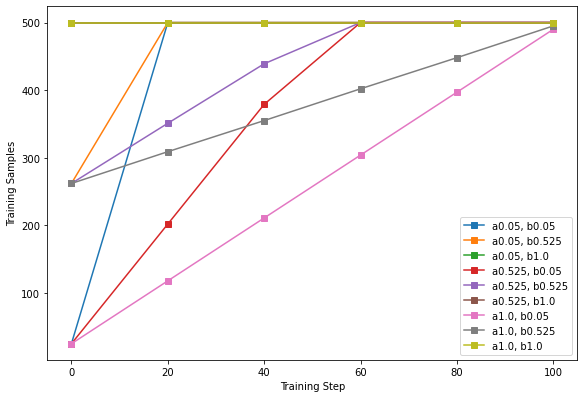

In [48]:
fig, ax = plt.subplots(figsize =(9.5, 6.5), nrows=1, sharex=True)

bs = args.local_bs
N = 500
epochs=2
myiterations = (N//bs+1)*epochs
args.pacing_f='linear'
args.pacing_a=0.2
args.pacing_b=0.2

pacing_a = np.linspace(0.05, 1, 3)
pacing_b = np.linspace(0.05, 1, 3)
startIter = 0
pacing_function = get_pacing_function(myiterations, N, args)

step=20

for a in pacing_a:
    for b in pacing_b:
        vec = []
        for s in range(0, myiterations, 20):
            args.pacing_f='linear'
            args.pacing_a=a
            args.pacing_b=b
            #print(step, a, b)
            pacing_function = get_pacing_function(myiterations, N, args)
            startIter_next = pacing_function(s)
            if startIter_next > N:
                startIter_next = N
            vec.append(copy.deepcopy(startIter_next))
        #print(vec)
        ax.plot(np.arange(0, myiterations, 20), vec, marker= 's', 
         label = 'a{}, b{}'.format(a, b))
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Training Samples')

        ax.legend(loc='best')


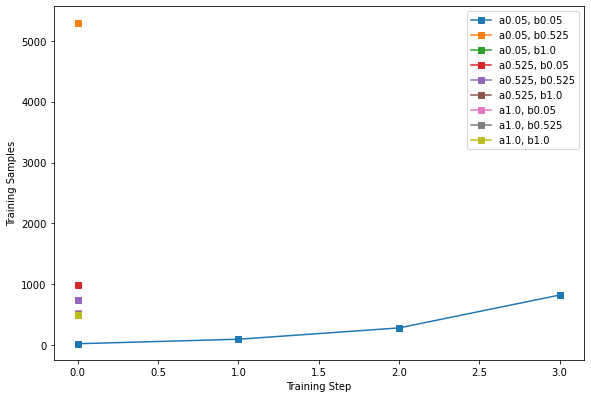

In [45]:
fig, ax = plt.subplots(figsize =(9.5, 6.5), nrows=1, sharex=True)

bs = args.local_bs
N = 500
epochs=args.local_ep
myiterations = (N//bs+1)*epochs
args.pacing_f='linear'
args.pacing_a=0.2
args.pacing_b=0.2

pacing_a = np.linspace(0.05, 1, 3)
pacing_b = np.linspace(0.05, 1, 3)
startIter = 0
pacing_function = get_pacing_function(myiterations, N, args)

step=0

for a in pacing_a:
    for b in pacing_b:
        vec = []
        
        args.pacing_f='linear'
        args.pacing_a=a
        args.pacing_b=b
        pacing_function = get_pacing_function(myiterations, N, args)
        startIter_next = pacing_function(step)
        NC = len(np.arange(startIter, max(startIter_next,32)))//bs + 1
        
        vec.append(copy.deepcopy(startIter_next))
        while step < myiterations:
            for n in np.arange(NC):
                step+=1 
            
            if startIter_next <= N:            
                startIter_next = pacing_function(step)
                NC = len(np.arange(startIter, max(startIter_next,32)))//bs + 1
                vec.append(copy.deepcopy(startIter_next))
                
        #print(vec)
        ax.plot(np.arange(len(vec)), vec, marker= 's', 
         label = 'a{}, b{}'.format(a, b))
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Training Samples')

        ax.legend(loc='best')


In [ ]:
bs = self.local_bs
N = len(order)
myiterations = (N//bs+1)*self.local_ep

iter_per_epoch = N//bs         
pre_iterations = 0
startIter = 0
step=0
pacing_function = self.get_pacing_function(myiterations, N)

startIter_next = pacing_function(step)
trainsets = Subset(self.lds_train, list(order[startIter:max(startIter_next,32)]))
ds_loader = DataLoader(trainsets, batch_size=self.local_bs, shuffle=True) 

epoch_loss = []
while step < myiterations:
    batch_loss = []
    for batch_idx, (images, labels) in enumerate(ds_loader):
        step+=1
        images, labels = images.to(self.device), labels.to(self.device)
        labels = labels.type(torch.LongTensor).to(self.device)

        self.net.zero_grad()
        #optimizer.zero_grad()
        log_probs = self.net(images)
        loss = self.loss_func(log_probs, labels)
        loss.backward() 

        optimizer.step()
        batch_loss.append(loss.item())

    epoch_loss.append(sum(batch_loss)/len(batch_loss))
    pre_iterations = step          
    if startIter_next <= N:            
        startIter_next = pacing_function(step)
        trainsets = Subset(self.lds_train, list(order[startIter:max(startIter_next,32)]))
        ds_loader = DataLoader(trainsets, batch_size=self.local_bs, shuffle=True)
